In [1]:
import os
import sys
import copy
import pathlib
import time
import random
import easydict

import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn

import numpy as np
from glob import glob
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"]='1, 2'

In [2]:
from dataloader.handhygiene import HandHygiene
# from dataloader.handhygiene import BalancedBatchSampler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import MultiStepLR
from train import get_models

from tensorboardX import SummaryWriter
from spatial_transforms import Compose
from spatial_transforms import Normalize
from spatial_transforms import Scale
from spatial_transforms import CenterCrop
from spatial_transforms import RandomHorizontalFlip
from spatial_transforms import RandomAffine
from spatial_transforms import RandomRotation
from spatial_transforms import ColorJitter
from spatial_transforms import ToTensor 
from temporal_transforms import TemporalRandomChoice
from temporal_transforms import TemporalRandomCrop
from temporal_transforms import LoopPadding, MirrorPadding, MirrorLoopPadding
from openpose_transforms import MultiScaleTorsoRandomCrop

In [3]:
from dataloader.handhygiene import get_classes


args = easydict.EasyDict({"seed": 100,
                          "mode": "binary",
                          "task": "detection",
                          "model_path": {"rgb": "model/model_rgb.pth", 
                                         "flow": "model/model_flow.pth"},
                          "label_list_path": "./data/annotations/hh_action_list.txt",
                          "annotation_path": "./data/annotations/hh_target.csv",
                          "label": get_classes('./data/annotations/hh_action_list.txt'),
                          "as_action": {"removing_gloves": "rubbing_hands",
                                        "wearing_gloves": "rubbing_hands"},
                          "steps":  {'touching_equipment': 1,
                                     'rubbing_hands': 1,
                                     'other_action': 3},
                          "class_weight": [1.25, 1.0, 1.0],
                          "img_size": 224,
                          "downsample_size": None,
                          "mean": [110.2008, 100.63983, 95.99475],
                          "std": [58.14765, 56.46975, 55.332195], 
                          "preproceed_optical_flow": False,
                          "frame_rate": None,
                          "fix_fov": True,
                          "crop_upper": True,
                          "align": False,
                          "padding": True,
                          "workers": 4, 
                          "epochs": 100, 
                          "start_epoch": 0,
                          "clip_len": 16,
                          "batch_size": 256,
                          "lr": 1e-4, # 1e-3,
                          "momentum": 0.9,
                          "weight_decay": 1e-6,
                          "world_size": 1,
                          "rank": 1,
                          "gpu": None,
                          "dist_backend": "nccl",
                          "multiprocessing": True,
                          "multiprocessing_distributed": False
                         })

random.seed(args.seed)
torch.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False

Training for classes rubbing_hands, touching_equipment, other_action


In [4]:
VIDEO_DIR='./data/images_new' #./data/videos


scales = np.linspace(0.75, 1.1, num=1000)
center = 1

openpose_transform = {
    'train':MultiScaleTorsoRandomCrop(scales, args.img_size),
    'val':MultiScaleTorsoRandomCrop(np.linspace(center, center, num=1), 
                                    args.img_size, centercrop=True)
}

spatial_transform = {
    'train': Compose([Scale(args.img_size),
                      CenterCrop(args.img_size),
                      RandomHorizontalFlip(),
                      ColorJitter(brightness=0.1),
                      ToTensor(1), 
                      Normalize(args.mean, args.std)
    ]),
    'val': Compose([Scale(args.img_size), 
                    CenterCrop(args.img_size), 
                    ToTensor(1), 
                    Normalize(args.mean, args.std)
    ])}

temporal_transform = {'train':Compose([ LoopPadding(args.clip_len) ]),
                     'val':LoopPadding(args.clip_len)}

dataset = {
    'train': HandHygiene(os.path.join(VIDEO_DIR, 'train'),
                         temporal_transform=temporal_transform['train'],
                         openpose_transform=openpose_transform['train'],
                         spatial_transform=spatial_transform['train'],
                         arguments = args
                        ),
    'val': HandHygiene(os.path.join(VIDEO_DIR, 'val'),
                       temporal_transform=temporal_transform['val'],
                       openpose_transform=openpose_transform['val'],
                       spatial_transform=spatial_transform['val'],
                       arguments = args
                      ),
}


100%|██████████| 13/13 [00:00<00:00, 77.08it/s]


Number of ./data/images_new/train video clips: 8675 (8272 images)
Number of clips:  {'rubbing_hands': 2794, 'touching_equipment': 2958, 'other_action': 2923}
Number of frames:  {'rubbing_hands': 5557, 'touching_equipment': 3961, 'other_action': 13494}
Total number of frames: {'rubbing_hands': 176542, 'touching_equipment': 383560, 'other_action': 327184}


100%|██████████| 3/3 [00:00<00:00, 16.30it/s]


Number of ./data/images_new/val video clips: 1453 (1668 images)
Number of clips:  {'rubbing_hands': 507, 'touching_equipment': 467, 'other_action': 479}
Number of frames:  {'rubbing_hands': 818, 'touching_equipment': 790, 'other_action': 2294}
Total number of frames: {'rubbing_hands': 35118, 'touching_equipment': 30733, 'other_action': 30329}


# Visualize a sample from dataset

[RGB] Filling cache for index 82
[Flow] Filling cache for index 82


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


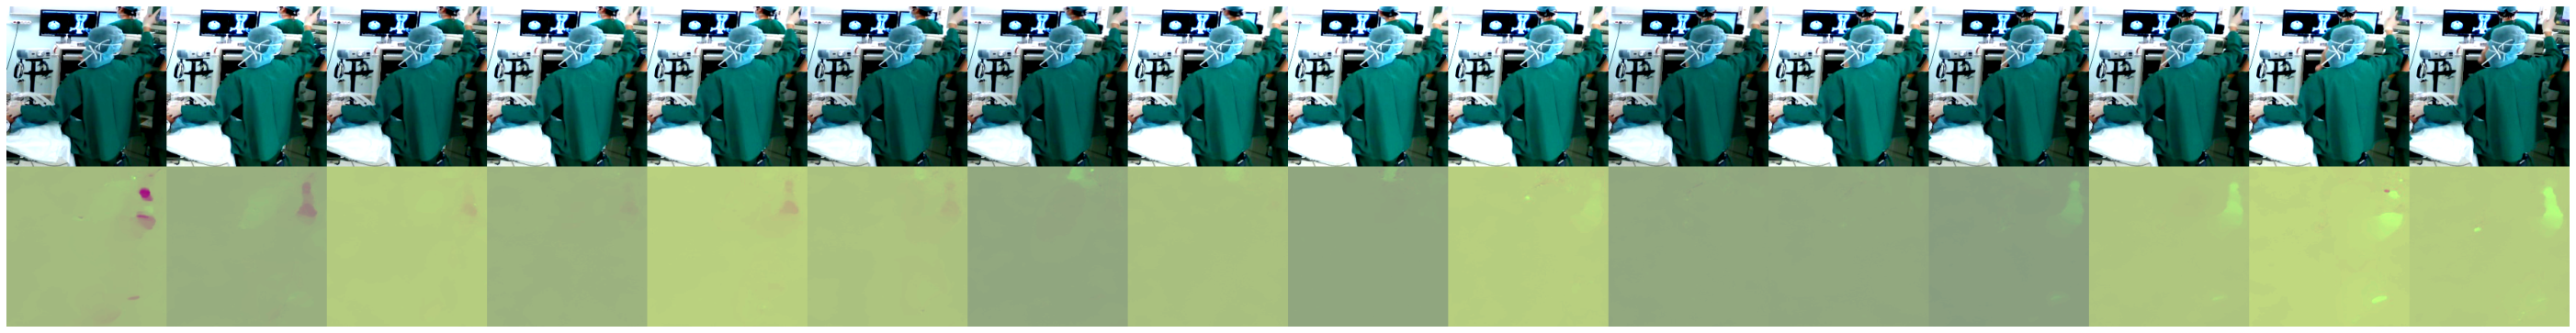

tensor(2)


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_dataset(items): # item: C x D x 244 x 244
    
    rgbs = items[0].transpose(0, 1)
    flows = items[1].transpose(0, 1)
    label = items[2]
    n = len(rgbs)
    shape = np.asarray(flows[0]).shape
    rgb = np.hstack((np.asarray(rgb).transpose(1, 2, 0)+1)/2 for rgb in rgbs)
    tmp = np.zeros((shape[1], shape[2], 1))
    flow = np.hstack((np.dstack((np.asarray(flow).transpose(1, 2, 0), tmp))+1)/2 for flow in flows)

    img = np.vstack((rgb, flow))
    plt.figure(figsize=(50, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print(label)
        #print('CLEAN' if item[2].item() == 0 else 'NOTCLEAN')
    
i=2400
phase='train'
show_dataset(dataset[phase][i])
(vidx, idx, person_idx, cidx, label), video_c = dataset[phase].video_clips.get_clip_location(i)
video_path = dataset[phase].video_clips.video_paths[vidx]

# Hyperparameters

In [6]:
# create model 
i3d_rgb, i3d_flow = get_models(len(args.label), True, 170, 
                               load_pt_weights=True,
                               rgb_weights_path=args.model_path.rgb,
                               flow_weights_path=args.model_path.flow)

if torch.cuda.device_count() > 1:
    i3d_rgb = torch.nn.DataParallel(i3d_rgb).cuda()
    i3d_flow = torch.nn.DataParallel(i3d_flow).cuda()

# hyperparameters / trainable parameters
optims={'rgb':None, 'flow':None}
schedulers = {'rgb':None, 'flow':None}
feature_extract=True


def trainable_params(model, mode='rgb'):
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    optims[mode] = torch.optim.SGD(model.parameters(), lr=args.lr, 
                                   momentum=args.momentum,
                                   weight_decay=args.weight_decay)

trainable_params(i3d_rgb, 'rgb')
trainable_params(i3d_flow, 'flow')

schedulers['rgb'] = MultiStepLR(optims['rgb'], milestones=[10], gamma=0.1)
schedulers['flow'] = MultiStepLR(optims['flow'], milestones=[10], gamma=0.1)

criterion = F.cross_entropy

dataloaders = {
        phase: DataLoader(
            dataset[phase], 
            shuffle=True if phase == 'train' else False,
            num_workers=args.workers, 
            #pin_memory=True, 
            batch_size=args.batch_size if phase=='train' else 1,
        )
        for phase in ['train', 'val']
    }

if args.multiprocessing:
    managers = {'train': mp.Manager(),
                'val'  : mp.Manager()}
#args['dataset'] = dataset

loading rgb weight from model/model_rgb.pth ....
loading flow weight from model/model_flow.pth ....
Params to learn:
	 module.conv3d_0c_1x1.0.conv3d.weight
	 module.conv3d_0c_1x1.0.conv3d.bias
	 module.conv3d_0c_1x1.1.conv3d.weight
	 module.conv3d_0c_1x1.1.conv3d.bias
Params to learn:
	 module.conv3d_0c_1x1.0.conv3d.weight
	 module.conv3d_0c_1x1.0.conv3d.bias
	 module.conv3d_0c_1x1.1.conv3d.weight
	 module.conv3d_0c_1x1.1.conv3d.bias


# Training

In [ ]:
from train import train
train((i3d_rgb, i3d_flow), 
          dataloaders, optims, 
          criterion,
          schedulers,
          args.epochs, 
          args.start_epoch,
          managers,
          args)